In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima







In [5]:
df=pd.read_csv('Denawaka_project.csv')
df.head()












,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,233.6,22.1,32.1,NaN,NaN
1,2010,February,111.9,22.6,33.9,NaN,NaN
2,2010,March,157.5,23.1,35.2,NaN,NaN
3,2010,April,438.3,23.7,33.5,NaN,NaN
4,2010,May,658.5,24.0,31.8,NaN,NaN


In [6]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)





In [7]:
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,233.6,22.1,32.1,NaN,NaN,2010-January
1,2010,February,111.9,22.6,33.9,NaN,NaN,2010-February
2,2010,March,157.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,438.3,23.7,33.5,NaN,NaN,2010-April
4,2010,May,658.5,24.0,31.8,NaN,NaN,2010-May


In [8]:
hum_max=df[["Time","Hum_max"]]
hum_max.head()








,Time,Hum_max
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [9]:
hum_max['Time']=pd.to_datetime(hum_max['Time'])

C:\Users\wasan\AppData\Local\Temp/ipykernel_10840/3416254753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_max['Time']=pd.to_datetime(hum_max['Time'])


In [10]:
hum_max.head(20)

,Time,Hum_max
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN
5,2010-06-01,NaN
6,2010-07-01,NaN
7,2010-08-01,NaN
8,2010-09-01,NaN
9,2010-10-01,NaN


In [11]:
#Checking for missing values
hum_max.isna().sum()






Time        0
Hum_max    23
dtype: int64

In [12]:
#Setting the time index
hum_max.set_index('Time',inplace=True)

In [13]:
hum_max=hum_max.resample('MS').first()

In [14]:
#filling missing values
hum=hum_max.fillna(method='bfill')
hum.head(20)






,Hum_max
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0
2010-06-01,95.0
2010-07-01,95.0
2010-08-01,95.0
2010-09-01,95.0


In [15]:
#Checking for missing values
hum.isna().sum()


Hum_max    0
dtype: int64

In [16]:
hum = hum.rename(columns = {'Hum_max': 'Humidity'})
hum.head()








,Humidity
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0


In [17]:
hum.columns



Index(['Humidity'], dtype='object')

In [18]:
hum.head()


,Humidity
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0


<AxesSubplot:xlabel='Time'>

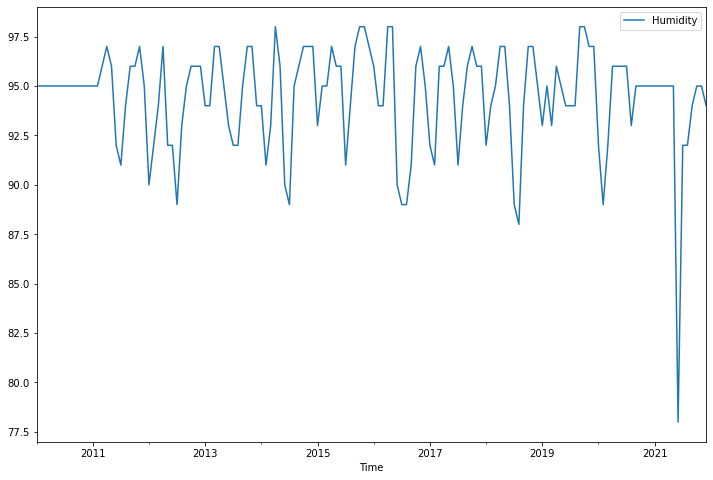

In [19]:
hum.plot(figsize=(12,8))



No trend. But some evidence for seasonality

# Testing For Stationarity

In [20]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])






ADF Test Statistic : -3.873088704854103
p-value : 0.0022420723600266013
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [21]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])


KPSS Statistic: 0.13309275505428483
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [22]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())





     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.442
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Therefore the series is stationary

# ACF and PACF plots

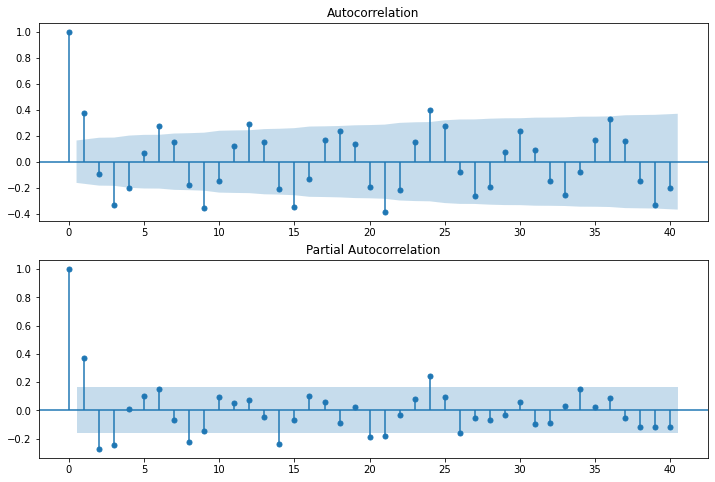

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)


According to the PACF and ACF plots, series is likely to follow a MA process. But since we are following step-wise, better to start with p=3,q=3, d=0

In [24]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_q=1,max_p=3,max_q=4,start_P=0,start_Q=0,max_P=3,max_Q=3,max_D=2,alpha=0.05,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,
                      information_criterion='aic')



 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=693.102, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=686.253, Time=0.14 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=668.567, Time=0.46 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=667.997, Time=1.24 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=679.304, Time=0.99 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=667.115, Time=1.39 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=670.576, Time=3.14 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=669.999, Time=4.54 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=696.536, Time=2.53 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=672.504, Time=4.42 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=24.14 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=698.920, Time=5.12 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=6.13 sec
 ARIMA(0,0,1)(0,0,0)[12] 

C:\Users\wasan\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(2,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=781.922, Time=9.41 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=671.480, Time=1.30 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=669.515, Time=1.42 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=658.924, Time=5.68 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=666.367, Time=2.37 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=667.197, Time=1.64 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=663.878, Time=3.26 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=654.805, Time=0.97 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=656.378, Time=1.81 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=669.751, Time=1.66 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=654.565, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=658.968, Time=0.26 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=660.227, Time=0.63 sec
 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=654.189, Time=1.44 sec
 ARIMA(3,0,0)(1

C:\Users\wasan\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,0)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=660.965, Time=1.11 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=662.184, Time=1.02 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=665.690, Time=1.54 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=663.693, Time=0.91 sec

Best model:  ARIMA(1,0,0)(1,0,3)[12] intercept
Total fit time: 317.449 seconds


# Forecast using the model

In [25]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(1,0,2),seasonal_order=(2,0,0,12))
results=model.fit()
results.summary()



C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Humidity   No. Observations:                  144
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 12)   Log Likelihood                -325.564
Date:                             Tue, 26 Apr 2022   AIC                            663.127
Time:                                     21:13:48   BIC                            680.946
Sample:                                 01-01-2010   HQIC                           670.368
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      1e-05   9.98e+04      0.000       1.000       1.000
ma.L1         -0.7044      0.092     -7.659      0.000      -0.885      -0.524
ma.L2         -0.2718      0.095     -2.872      0.004      -0.457      -0.086
ar.S.L12       0.1863      0.142      1.314      0.189      -0.092       0.464
ar.S.L24       0.3971      0.116      3.433      0.001       0.170       0.624
sigma2         4.8689      0.207     23.521      0.000       4.463       5.275
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              2803.46
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               3.52   Skew:                            -3.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
hum.head()

,Humidity
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0


In [27]:
hum.tail()

,Humidity
Time,
2021-08-01,92.0
2021-09-01,94.0
2021-10-01,95.0
2021-11-01,95.0
2021-12-01,94.0


In [28]:
beg_dt='2025-01-01'
end_dt='2025-01-01'

In [29]:
results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


2025-01-01    93.78803
Freq: MS, dtype: float64

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='Time'>

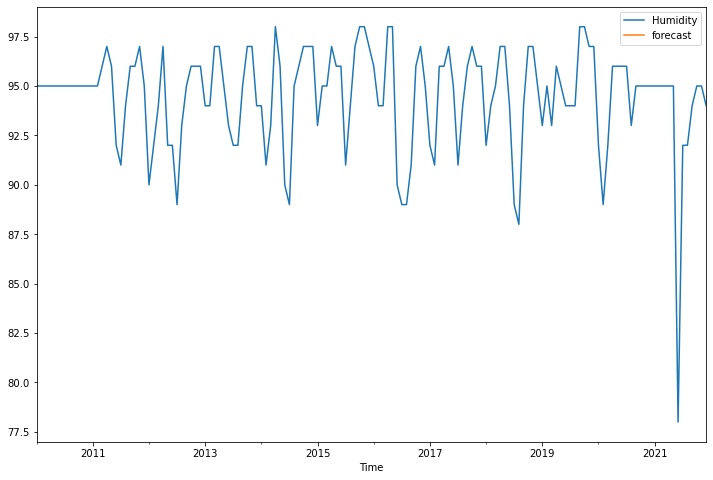

In [30]:
hum['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))




In [26]:
hum.tail()



,Humidity,forecast
Time,,
2021-08-01,92.0,93.958850
2021-09-01,94.0,94.394411
2021-10-01,95.0,94.966807
2021-11-01,95.0,95.065281
2021-12-01,94.0,94.788438
